In [2]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# import attention_conv.model as modelsrc
import unet.model2 as modelsrc
# import stupid_simple_conv.model as modelsrc
from main_dataset import CHMainDataset, SingleCropGenerator
from chunkified_npset import ChunkifiedDataset
from loss import MS_SSIMLoss
from optim.lamb import Lamb
import os
import imp
import pickle
from datetime import datetime

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
imp.reload(modelsrc)
ModelToTest = modelsrc.UNetPPDropoutMulti
params = []

Training Setup

In [5]:
BATCH_LEN = 16 #still depends on its_til_update for true loss batch size
EPOCHS = 100

Training utilities
# wow

Training loop definition

In [6]:
dir_to_save = 'other_state_dicts/unetppmulti'
if not os.path.isdir(dir_to_save):
    os.makedirs(dir_to_save)

In [7]:
def train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch, name_list):
    its_til_checkpoint = 20
    its_til_cleanup = 200
    its_til_update = 1
    
    epoch_running_loss = 0
    epoch_count = 0
    running_loss = 0
    count = 0
    optimizer.zero_grad()
    model.train()
    for i, (features, targets) in enumerate(dataloader):
        features = features.to(device)
        targets = targets.to(device)

        predictions = model(features)

        loss = criterion(predictions.unsqueeze(2), targets.unsqueeze(2))
        loss.backward()

        curr_len = features.shape[0]
        running_loss += curr_len * loss.item()
        count += curr_len
        epoch_running_loss += curr_len * loss.item()
        epoch_count += curr_len
        
        losses.append(loss.item())
        
        if i % its_til_update == its_til_update-1:
            print(f'Peforming update on model with batch_size - {its_til_update * BATCH_LEN}')
            optimizer.step()
            optimizer.zero_grad()
        
        print(f'Iteration {i} - batch size: {curr_len}')
        
        if i % its_til_checkpoint == its_til_checkpoint-1:
            curr_loss = running_loss / count
            print(f'Current loss after {its_til_checkpoint} iterations: {curr_loss}')

            plt.plot(losses, 'b-')
            plt.title("Loss over iterations")
            plt.show()

            file_name = f'epoch-{epoch}_iteration-{i}_loss-{curr_loss}'
            torch.save(model.state_dict(), os.path.join(dir_to_save, file_name))
            name_list.append(file_name)

            running_loss = 0
            count = 0
        
        if i % its_til_cleanup == its_til_cleanup - 1:
            #remove old entries
            for name in name_list[:-8]:
                path = os.path.join(dir_to_save, name)
                if os.path.isfile(path):
                    os.remove(path)
            name_list = name_list[-8:]
            
        if i == 1440: #rando early break lul
            break
    
    epoch_losses.append(epoch_running_loss / epoch_count)

In [8]:
def train(epochs, dataset, batch_size, model, optimizer, criterion):
    losses = []
    epoch_losses = []
    dataloader = DataLoader(dataset, batch_size=batch_size)
    name_list = []
    try:
        for epoch in range(epochs):
            print(f'Entering epoch {epoch}')
            train_epoch(dataloader, model, optimizer, criterion, losses, epoch_losses, epoch, name_list)
            print(f'Loss for epoch {epoch} - {epoch_losses[-1]}')
            plt.plot(epoch_losses, 'r-')
            plt.title('Epoch Losses')
            plt.show()

            #remove old entries
            for name in name_list[:-5]:
                path = os.path.join(dir_to_save, name)
                if os.path.isfile(path):
                    os.remove(path)
            name_list = name_list[-5:]

            with open(os.path.join(dir_to_save, 'epoch_losses'), 'wb') as f:
                pickle.dump(epoch_losses, f)
            f.close()
    except Exception as e: #catch any error and log em!
        with open(os.path.join(dir_to_save, 'error.txt'), 'a') as f:
            f.write(str(e))
        f.close()
    
    # time of finish
    with open(os.path.join(dir_to_save, 'time_of_finish.txt'), 'a') as f:
        now = datetime.now()
        dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
        f.write(dt_string)
    f.close()
    
    return losses

In [9]:
np_set = ChunkifiedDataset()
gen = SingleCropGenerator(np_set[0].shape[0], np_set[0].shape[1])
dataset = CHMainDataset(np_set, gen)
dataset[0][1].shape

(24, 64, 64)

In [10]:
# preprocess = ImagesPreprocess()
# model = PerceiverCH(preprocess, latent_dim=(32, 128), heads=8, wide_factor=4, latent_count=6)
model = ModelToTest()
model.to(device)
msssim = MS_SSIMLoss(channels=24)
l1 = torch.nn.L1Loss()
criterion = lambda pred, target: msssim(pred,target) #+ l1(pred,target) 

Entering epoch 0
Peforming update on model with batch_size - 16
Iteration 0 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 1 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 2 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 3 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 4 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 5 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 6 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 7 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 8 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 9 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 10 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 11 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 12 - batch s

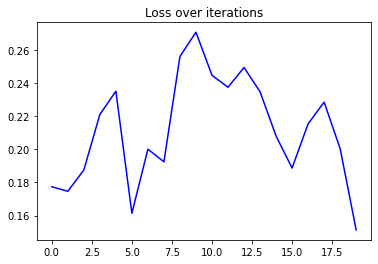

Peforming update on model with batch_size - 16
Iteration 20 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 21 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 22 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 23 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 24 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 25 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 26 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 27 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 28 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 29 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 30 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 31 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 32 - batch size: 16

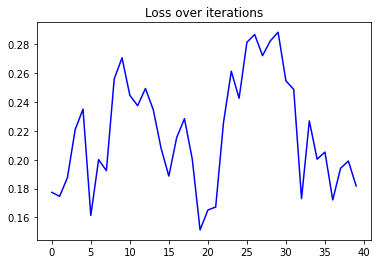

Peforming update on model with batch_size - 16
Iteration 40 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 41 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 42 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 43 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 44 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 45 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 46 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 47 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 48 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 49 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 50 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 51 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 52 - batch size: 16

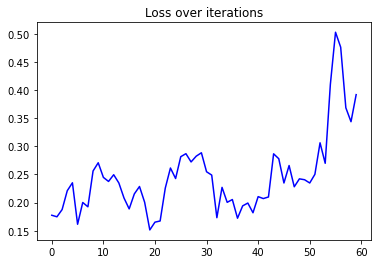

Peforming update on model with batch_size - 16
Iteration 60 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 61 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 62 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 63 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 64 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 65 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 66 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 67 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 68 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 69 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 70 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 71 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 72 - batch size: 16

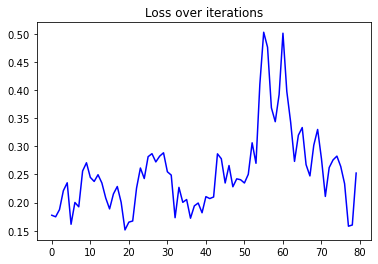

Peforming update on model with batch_size - 16
Iteration 80 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 81 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 82 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 83 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 84 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 85 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 86 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 87 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 88 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 89 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 90 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 91 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 92 - batch size: 16

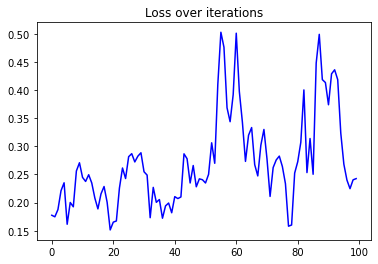

Peforming update on model with batch_size - 16
Iteration 100 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 101 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 102 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 103 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 104 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 105 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 106 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 107 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 108 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 109 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 110 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 111 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 112 - b

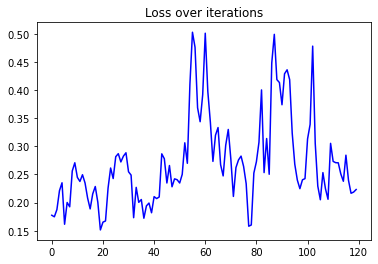

Peforming update on model with batch_size - 16
Iteration 120 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 121 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 122 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 123 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 124 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 125 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 126 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 127 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 128 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 129 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 130 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 131 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 132 - b

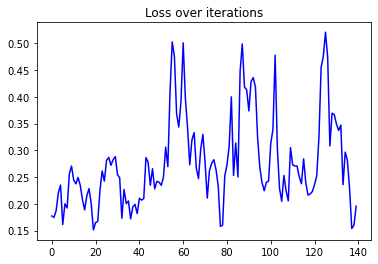

Peforming update on model with batch_size - 16
Iteration 140 - batch size: 16
Peforming update on model with batch_size - 16
Iteration 141 - batch size: 16


In [ ]:
optimizer = Lamb(model.parameters())
train(EPOCHS, dataset, BATCH_LEN, model, optimizer, criterion)

#### Lets see the results


tensor([[80.0624, 65.8758, 67.0400,  ..., 78.0135, 71.3976, 93.1061],
        [64.1297, 64.4814, 74.4480,  ..., 75.8463, 66.2291, 70.7437],
        [55.5121, 54.8840, 58.7106,  ..., 69.6389, 63.2932, 70.4920],
        ...,
        [54.3015, 58.8667, 61.3452,  ..., 60.9829, 60.7885, 56.3898],
        [59.6632, 54.7159, 57.0995,  ..., 62.0646, 65.1311, 66.6574],
        [78.1604, 67.1153, 60.4119,  ..., 65.2296, 68.4939, 79.1296]])
tensor([[69.8951, 67.3787, 66.1303,  ..., 75.6093, 75.7727, 79.8236],
        [62.1567, 61.1045, 60.6442,  ..., 71.0357, 74.7200, 66.5328],
        [59.4681, 53.7154, 53.2252,  ..., 60.7227, 55.6668, 59.6336],
        ...,
        [54.9275, 62.6212, 62.2819,  ..., 59.4543, 56.0162, 53.3739],
        [55.6034, 56.8954, 52.8893,  ..., 58.9997, 55.8250, 62.7674],
        [71.9544, 63.1113, 62.6997,  ..., 68.3029, 62.8659, 77.3049]])
tensor([[73.2017, 67.5700, 66.4372,  ..., 72.4031, 71.2059, 84.5529],
        [64.3486, 65.6431, 66.4483,  ..., 69.5323, 64.2729, 77

tensor([[43.4383, 34.8823, 34.7589,  ..., 46.5438, 40.0051, 58.1257],
        [30.9308, 37.4834, 45.7572,  ..., 47.7314, 38.1536, 41.5653],
        [30.9097, 33.5840, 37.2315,  ..., 45.2597, 37.7038, 45.1031],
        ...,
        [32.7399, 37.1876, 44.1180,  ..., 46.1642, 45.9438, 40.9964],
        [38.0606, 33.5478, 38.7209,  ..., 44.9719, 48.8786, 48.7784],
        [51.6787, 44.9222, 40.4835,  ..., 48.3604, 50.1563, 59.7266]])
tensor([[30.0343, 35.8595, 34.9368,  ..., 46.3965, 44.2476, 45.1889],
        [30.0143, 36.2682, 34.5098,  ..., 42.9583, 44.9848, 37.1501],
        [34.4023, 28.6932, 26.7940,  ..., 37.1596, 31.6361, 34.1165],
        ...,
        [32.0870, 45.6396, 45.6389,  ..., 45.5007, 42.5332, 38.6847],
        [32.9766, 37.0354, 34.4050,  ..., 42.9407, 40.1296, 46.1687],
        [45.6646, 42.1450, 42.6389,  ..., 51.2257, 46.3369, 57.8346]])
tensor([[35.5175, 36.2327, 32.6925,  ..., 41.3766, 39.4640, 49.5662],
        [31.2385, 40.5299, 37.8003,  ..., 40.4063, 36.5795, 45

tensor([[43.1255, 34.6081, 34.4824,  ..., 46.2319, 39.6810, 57.7598],
        [30.6581, 37.2752, 45.4900,  ..., 47.4715, 37.8818, 41.2682],
        [30.7196, 33.4152, 37.0912,  ..., 45.0411, 37.4742, 44.8631],
        ...,
        [32.6741, 37.1117, 44.0420,  ..., 46.2078, 45.9833, 41.0271],
        [37.9817, 33.4710, 38.6381,  ..., 45.0216, 48.9140, 48.8164],
        [51.5846, 44.8271, 40.3905,  ..., 48.3977, 50.1971, 59.7650]])
tensor([[29.7500, 35.6155, 34.6598,  ..., 46.1334, 43.9367, 44.8581],
        [29.7747, 36.0871, 34.2922,  ..., 42.7232, 44.7086, 36.8945],
        [34.1963, 28.5516, 26.6096,  ..., 36.9944, 31.4419, 33.9138],
        ...,
        [32.0158, 45.5720, 45.5671,  ..., 45.5402, 42.5610, 38.7164],
        [32.9027, 36.9552, 34.3431,  ..., 42.9756, 40.1553, 46.1979],
        [45.5726, 42.0590, 42.5403,  ..., 51.2683, 46.3647, 57.8700]])
tensor([[35.2067, 35.9700, 32.3759,  ..., 41.0980, 39.1757, 49.2247],
        [30.9566, 40.3241, 37.5350,  ..., 40.1733, 36.3605, 45

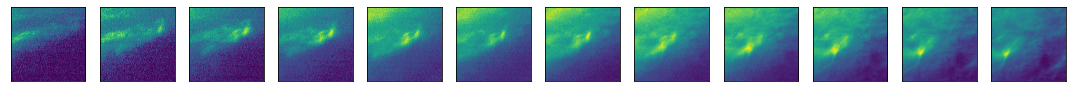

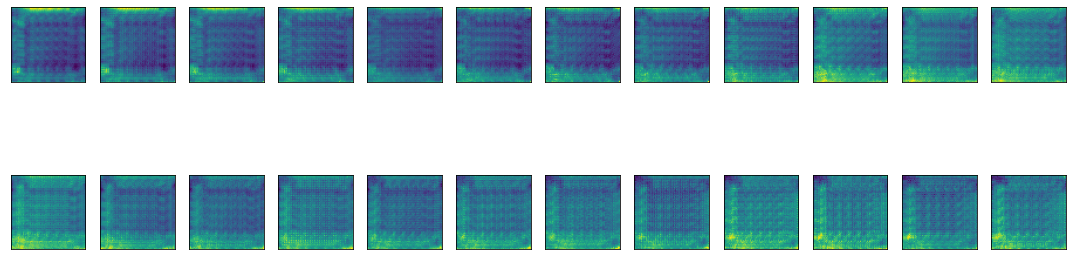

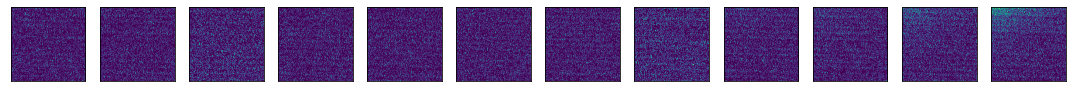

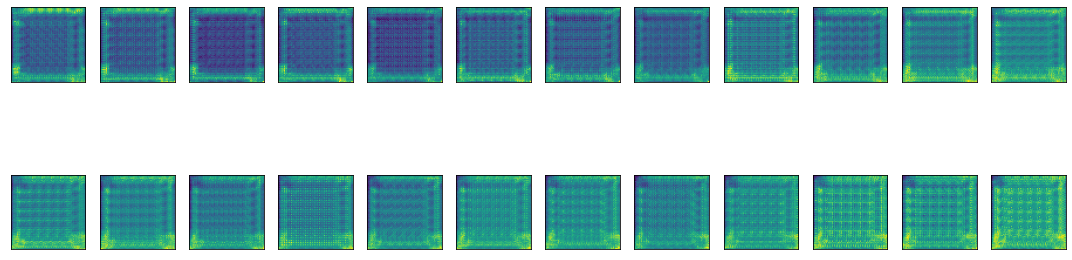

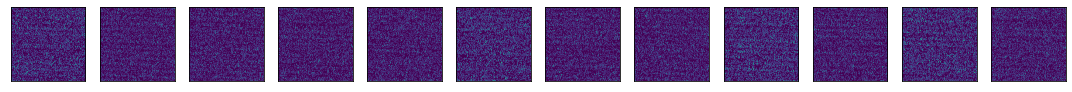

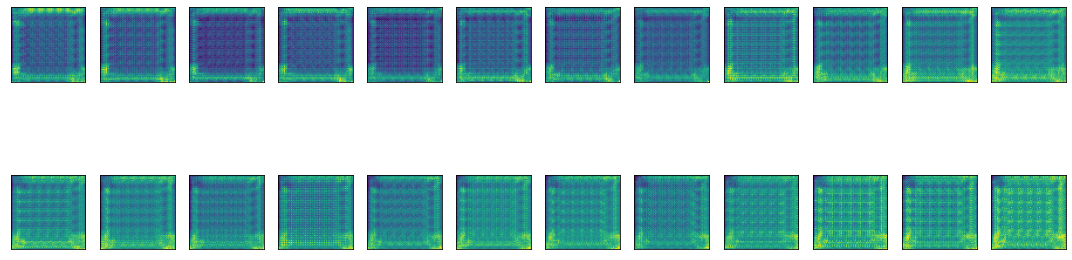

In [31]:
model.eval()
garbo = [dataset[i] for i in range(10, 13)]
for i, (features, targets) in enumerate(garbo):
    if i == 6:
        break
    
    fig, axs = plt.subplots(1, 12, figsize=(15, 3))
    for f_no, ax in enumerate(axs):
        ax.imshow(features[f_no], cmap='viridis')
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)
    fig.tight_layout()
    fig.show()
    
    features = torch.tensor(features).unsqueeze(0).to(device)
    predictions = model(features)
    fig, axs = plt.subplots(2, 12, figsize=(15, 6))
    predictions = predictions.squeeze()
    predictions = predictions.detach().cpu()
    p_no = 0
    for chonky in axs:
        for ax in chonky:
            ax.imshow(predictions[p_no], cmap='viridis')
            ax.get_yaxis().set_visible(False)
            ax.get_xaxis().set_visible(False)
            print(predictions[p_no])
            p_no += 1
    fig.tight_layout()
    
    fig.show()

In [21]:
model.load_state_dict(torch.load(os.path.join(dir_to_save, 'epoch-1_iteration-999_loss-0.18896082639694214'), map_location=device))

<All keys matched successfully>

In [17]:
garbo = model.transformer.in_pe.expand(5, -1, -1)
garbo.device

device(type='cuda', index=0)

In [14]:
print(torch.mean(model.process.q_out))

tensor(-1.7162e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
plt.plot(losses, 'b-')
plt.set_title("THe losses wow")
plt.show()